# Developing and training large scale neural networks (CNN) in PyTorch and geospatial visualisation of the Particulate matter 2.5 µm size data

In [1]:
# pip install cfgrib xarray eccodes

In [36]:
import cdsapi
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import os
import torch
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

#### Downloading CAMS data

In [37]:
dataset = "cams-global-reanalysis-eac4"
variable = "particulate_matter_2.5um"
request = {
    "variable": [variable],
    "date": ["2024-01-01/2024-12-31"],
    "time": [
        "00:00", "03:00", "06:00",
        "09:00", "12:00", "15:00",
        "18:00", "21:00"
    ],
    "data_format": "grib",
    "area": [50, -135, 25, -90]
}

client = cdsapi.Client()

filename = f"{variable}.grib"
client.retrieve(dataset, request).download(filename)


2025-06-16 14:33:02,704 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here]([https://status.ecmwf.int](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)/)
2025-06-16 14:33:02,705 INFO [2025-06-10T00:00:00] To improve our CAMS service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/CruBEQ/). Thank you.
2025-06-16 14:33:02,705 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-16 14:33:02,969 INFO Request ID is 2c0644ee-0786-4dba-8170-48cc59952859
2025-06-16 14:33:03,214 INFO status has been updated to accepted
2025-06-16 14:33:17,135 INFO status has been updated to successful


7ff6d6fb8247beda3ca69675bd1f9f3f.grib:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

'particulate_matter_2.5um.grib'

In [3]:
print(os.path.exists("particulate_matter_2.5um.grib"))  # Should return True
print(os.path.getsize("particulate_matter_2.5um.grib"))  # Should be > 0 (not empty)

True
18534240


In [14]:
# Load GRIB file
ds = xr.open_dataset('particulate_matter_2.5um.grib', engine='cfgrib', decode_timedelta=False)

# Extract PM2.5 variable
data = ds['pm2p5']  # dims: (time, lat, lon) or (lat, lon)

# Convert to numpy
data_np = data.values  # shape: (time, lat, lon) or (lat, lon)

# Handle case with no time dimension
if data_np.ndim == 2:
    data_np = data_np[np.newaxis, :, :]

print(f"Original Data shape: {data_np.shape}")

# Apply log transformation with a small epsilon to avoid log(0)
epsilon = 1e-6
log_data_np = np.log(data_np + epsilon)

print(f"Log-transformed data stats - min: {np.min(log_data_np):.2f}, max: {np.max(log_data_np):.2f}")


Ignoring index file 'particulate_matter_2.5um.grib.5b7b6.idx' older than GRIB file


Original Data shape: (2928, 34, 61)
Log-transformed data stats - min: -13.82, max: -12.24


In [ ]:
data

#### Prepare input-output samples

In [15]:
# Create input-output pairs (X = t, Y = t+1)
X = log_data_np[:-1]  # all but last time step
Y = log_data_np[1:]   # all but first time step

print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(X.min(), X.max(), Y.min(), Y.max())


X shape: (2927, 34, 61), Y shape: (2927, 34, 61)
-13.815511 -12.241726 -13.815511 -12.241726


#### Convert to PyTorch tensors and dataset

In [16]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, Y_tensor)

# Train/test split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)


#### Define a simple CNN model (for spatial data)

In [17]:
class PM25PredictorCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # shape: [B, 16, 34, 61]
        x = F.relu(self.conv2(x))  # shape: [B, 32, 34, 61]
        x = F.relu(self.conv3(x))  # shape: [B, 16, 34, 61]
        x = self.conv4(x)          # shape: [B, 1, 34, 61]
        return x

model = PM25PredictorCNN()


#### Training loop

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb = xb.unsqueeze(1).to(device)  # add channel dim
        yb = yb.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.unsqueeze(1).to(device)
            yb = yb.unsqueeze(1).to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f} - Val loss: {val_loss:.4f}")


Epoch 1/10 - Train loss: 13.9810 - Val loss: 0.0716
Epoch 2/10 - Train loss: 0.0399 - Val loss: 0.0246
Epoch 3/10 - Train loss: 0.0176 - Val loss: 0.0120
Epoch 4/10 - Train loss: 0.0088 - Val loss: 0.0064
Epoch 5/10 - Train loss: 0.0050 - Val loss: 0.0038
Epoch 6/10 - Train loss: 0.0031 - Val loss: 0.0024
Epoch 7/10 - Train loss: 0.0020 - Val loss: 0.0016
Epoch 8/10 - Train loss: 0.0014 - Val loss: 0.0012
Epoch 9/10 - Train loss: 0.0010 - Val loss: 0.0009
Epoch 10/10 - Train loss: 0.0008 - Val loss: 0.0007


C:\Users\soura\AppData\Local\Temp\ipykernel_11440\3512993470.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 0.97])


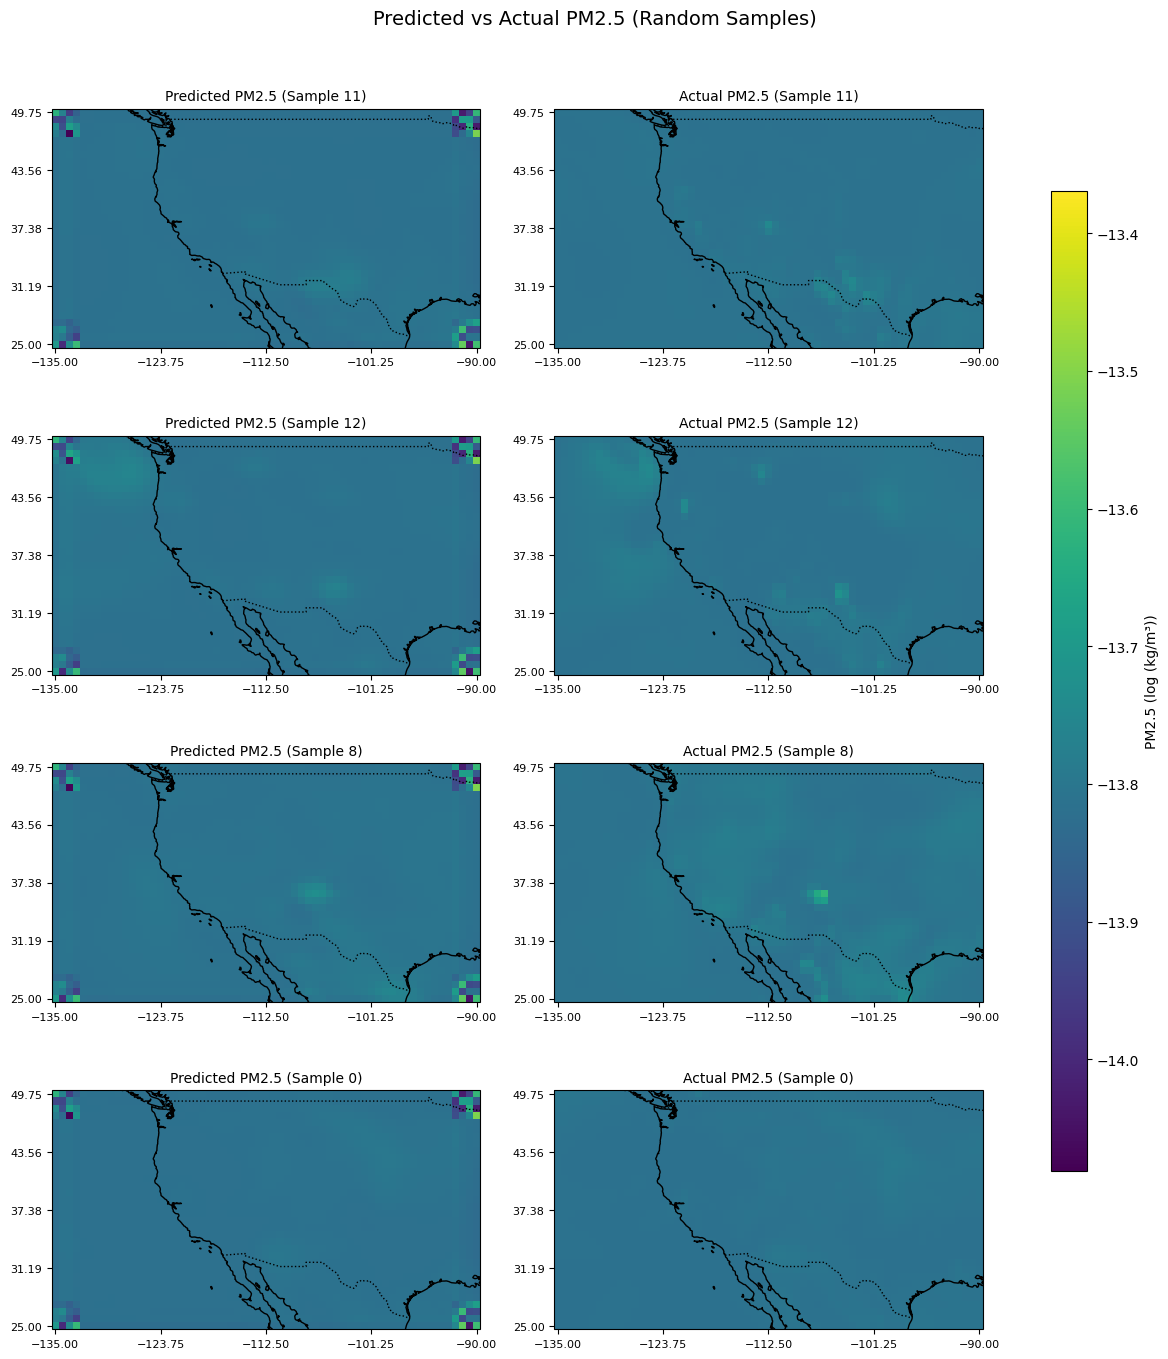

In [33]:
# Number of samples to plot
N = min(4, preds.shape[0])

# Randomly choose N unique indices from the batch
random_indices = random.sample(range(preds.shape[0]), N)

fig, axes = plt.subplots(N, 2, figsize=(12, 3.5 * N), subplot_kw={'projection': ccrs.PlateCarree()})

vmin = min(preds.min(), actuals.min())
vmax = max(preds.max(), actuals.max())

for i, idx in enumerate(random_indices):
    # Predicted
    ax = axes[i, 0] if N > 1 else axes[0]
    pm = ax.pcolormesh(lon_grid, lat_grid, preds[idx], cmap='viridis', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"Predicted PM2.5 (Sample {idx})", fontsize=10)
    ax.set_xticks(np.linspace(lons.min(), lons.max(), 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(lats.min(), lats.max(), 5), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)

    # Actual
    ax = axes[i, 1] if N > 1 else axes[1]
    ax.pcolormesh(lon_grid, lat_grid, actuals[idx], cmap='viridis', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_title(f"Actual PM2.5 (Sample {idx})", fontsize=10)
    ax.set_xticks(np.linspace(lons.min(), lons.max(), 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.linspace(lats.min(), lats.max(), 5), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)

# Adjust layout to make space for the colorbar on the right
plt.subplots_adjust(right=0.85)

# Create colorbar axes to the right of the subplots
cbar_ax = fig.add_axes([0.88, 0.15, 0.03, 0.7])  # [left, bottom, width, height] in figure fraction

# Add colorbar
fig.colorbar(pm, cax=cbar_ax, label='PM2.5 (log (kg/m³))')

plt.suptitle("Predicted vs Actual PM2.5 (Random Samples)", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 0.97])
plt.show()


## Visualization of geospatial data of particulate matter 2.5 um distribution

Ignoring index file 'particulate_matter_2.5um.grib.5b7b6.idx' older than GRIB file


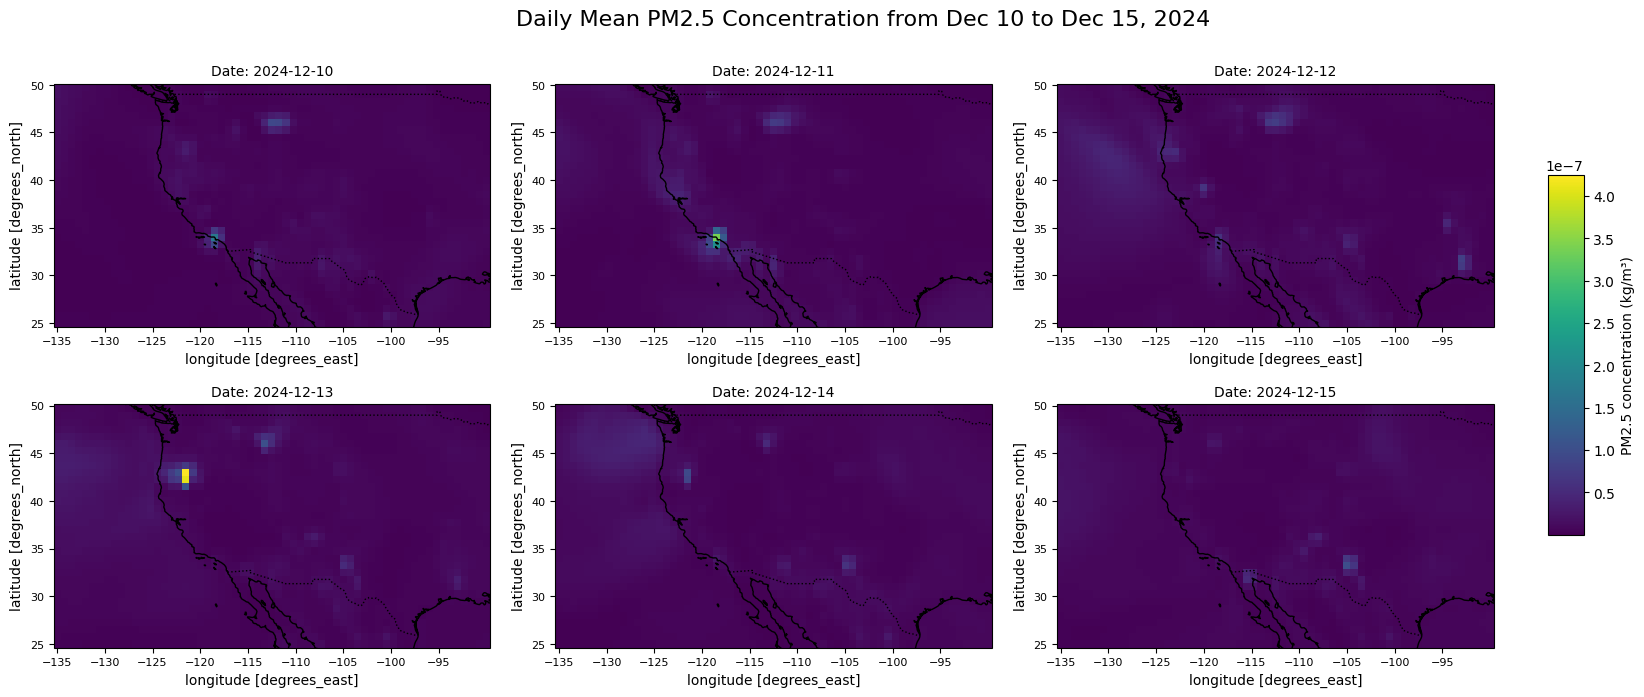

In [34]:
# Open GRIB file
ds = xr.open_dataset('particulate_matter_2.5um.grib', engine='cfgrib', decode_timedelta=False)
particulate_2_5 = ds['pm2p5']

# Convert time to pandas datetime
time_values = pd.to_datetime(particulate_2_5['time'].values)

# Define date range
start_date = pd.Timestamp("2024-12-10")
end_date = pd.Timestamp("2024-12-15")

# Create a new coordinate with just the date (no time)
date_only = pd.to_datetime(particulate_2_5['time'].values).normalize()
particulate_2_5.coords['date'] = ('time', date_only)

# Filter by date range
mask = (date_only >= start_date) & (date_only <= end_date)
particulate_filtered = particulate_2_5.isel(time=np.where(mask)[0])

# Group by date and calculate daily mean
daily_mean = particulate_filtered.groupby('date').mean('time')

# Plotting
n_plots = len(daily_mean)
n_cols = 3
n_rows = int(np.ceil(n_plots / n_cols))

fig = plt.figure(figsize=(6 * n_cols, 3.6 * n_rows))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, hspace=0.05, wspace=0.15)  # tight vertical spacing

axes = []
for i in range(n_plots):
    ax = fig.add_subplot(gs[i], projection=ccrs.PlateCarree())
    axes.append(ax)

# Determine color scale range
vmin = float(daily_mean.min())
vmax = float(daily_mean.max())

for i, date in enumerate(daily_mean['date'].values):
    ax = axes[i]
    da = daily_mean.sel(date=date)

    im = da.plot.pcolormesh(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='viridis',
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False
    )

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks(np.arange(-135, -91, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(25, 51, 5), crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.set_title(f'Date: {np.datetime_as_string(date, unit="D")}', fontsize=10)

# Remove any unused subplots
# for i in range(n_plots, len(axes)):
#     fig.delaxes(axes[i])

# Adjust layout to make space for the colorbar
plt.subplots_adjust(left=0.05, right=0.85, top=0.92, bottom=0.05, hspace=0.05, wspace=0.2)  # Shrink width to make room for colorbar

# Add a colorbar to the right of all subplots
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('PM2.5 concentration (kg/m³)')

fig.suptitle('Daily Mean PM2.5 Concentration from Dec 10 to Dec 15, 2024', fontsize=16)
plt.show()